Step1: Import all the required Libraries to build the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Step 2: Step 2: Upload the dataset in Google Colab. If we are using Jupyter Notebook, then we can directly access the dataset from our local system using read_csv().

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
import io
ctg = pd.read_csv(io.BytesIO(uploaded['CTG.csv']))

Step 3: Get more information about the dataset.

In [ ]:
ctg.head(10)

LB   AC   FM    UC  ASTV  ...   Mean  Median  Variance  Tendency  NSP
0  120.0  0.0  0.0   0.0  73.0  ...  137.0   121.0      73.0       1.0  2.0
1  132.0  4.0  0.0   4.0  17.0  ...  136.0   140.0      12.0       0.0  1.0
2  133.0  2.0  0.0   5.0  16.0  ...  135.0   138.0      13.0       0.0  1.0
3  134.0  2.0  0.0   6.0  16.0  ...  134.0   137.0      13.0       1.0  1.0
4  132.0  4.0  0.0   5.0  16.0  ...  136.0   138.0      11.0       1.0  1.0
5  134.0  1.0  0.0  10.0  26.0  ...  107.0   107.0     170.0       0.0  3.0
6  134.0  1.0  0.0   9.0  29.0  ...  107.0   106.0     215.0       0.0  3.0
7  122.0  0.0  0.0   0.0  83.0  ...  122.0   123.0       3.0       1.0  3.0
8  122.0  0.0  0.0   1.0  84.0  ...  122.0   123.0       3.0       1.0  3.0
9  122.0  0.0  0.0   3.0  86.0  ...  122.0   123.0       1.0       1.0  3.0

[10 rows x 23 columns]

Step 4: Fill the missing values with Mode for the target variable: NPS

In [ ]:
ctg['NSP'].fillna(ctg['NSP'].mode()[0], inplace=True)

Step 5: Get the data distribution for different values of target variable: 'NSP'. Rest of the features present in the datset are Predictors.

In [ ]:
count_classes = pd.value_counts(ctg['NSP'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("NSP Distribution")

plt.xlabel("NSP")
plt.ylabel("Frequency")

Step 6: Discard all the datapoints having NSP=2, as this is not of our interest.
Step 7: Count the no. of data points for 'Normal' and 'Outlier' classes

In [ ]:
ctg=ctg.dropna()
ctg=ctg.drop(ctg[ctg['NSP']==2].index)

ctg.shape
pd.value_counts(ctg['NSP'])

(1831, 23)

Step 8: Split the train, test data.

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x = train_test_split(ctg, test_size=0.3, random_state=42)
train_x = train_x[train_x.NSP == 1] #where normal transactions
train_x = train_x.drop(['NSP'], axis=1) #drop the class column

test_y = test_x['NSP'] #save the class column for the test set
test_x = test_x.drop(['NSP'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values
train_x.shape, test_x.shape

((1155, 22), (550, 22))

Step 9: Build the model with input_dim=1 (for 2 class classifier), encoding_dim=12. Activation function=tanh for encoder layer and sigmoid for decoder layer.

In [ ]:
encoding_dim=12
input_dim=train_x.shape[1]
inputArray=Input(shape=(input_dim,))
encoded=Dense(encoding_dim, activation='tanh')(inputArray)
decoded=Dense(input_dim, activation='softmax')(encoded)
autoencoder=Model(inputArray, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 12)                276       
_________________________________________________________________
dense_1 (Dense)              (None, 22)                286       
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


Step 10: Compile the model with optimizer=ADAM, loss=binary-crossentropy and metrics=accuracy. 

Step 11: Fit the model with batch_size=32 and epochs=20.

Step 12: Evaluate the model.


In [ ]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

batch_size=32
epochs=20
history=autoencoder.fit(train_x,train_x,batch_size=batch_size,epochs=epochs,verbose=1,shuffle=True,
                        validation_data=(test_x,test_x))

score=autoencoder.evaluate(test_x, test_x, verbose=1)
print('Test loss:', score[0])
print('Accuracy:', score[1])

Epoch 1/20
37/37 [==============================] - 0s 6ms/step - loss: 115.6666 - accuracy: 0.0000e+00 - val_loss: 109.3216 - val_accuracy: 0.0000e+00
Epoch 2/20
37/37 [==============================] - 0s 2ms/step - loss: 103.1119 - accuracy: 0.5221 - val_loss: 101.6813 - val_accuracy: 0.9236
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 97.8719 - accuracy: 0.9662 - val_loss: 98.1234 - val_accuracy: 0.9327
Epoch 4/20
37/37 [==============================] - 0s 2ms/step - loss: 95.2404 - accuracy: 0.9740 - val_loss: 96.1530 - val_accuracy: 0.9400
Epoch 5/20
37/37 [==============================] - 0s 2ms/step - loss: 93.8660 - accuracy: 0.9827 - val_loss: 95.1836 - val_accuracy: 0.9436
Epoch 6/20
37/37 [==============================] - 0s 2ms/step - loss: 93.1654 - accuracy: 0.9844 - val_loss: 94.6576 - val_accuracy: 0.9418
Epoch 7/20
37/37 [==============================] - 0s 2ms/step - loss: 92.7569 - accuracy: 0.9861 - val_loss: 94.3430 - val_accuracy: 0

Step 13:  Reconstruction Error and True Class

In [ ]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

Reconstruction_error  True_class
count            550.000000  550.000000
mean            5562.154069    1.181818
std             1291.395353    0.575483
min             3478.088973    1.000000
25%             4798.310651    1.000000
50%             5478.062889    1.000000
75%             6110.177241    1.000000
max            19915.746533    3.000000

Step 14: Plotting the Confusion Matrix

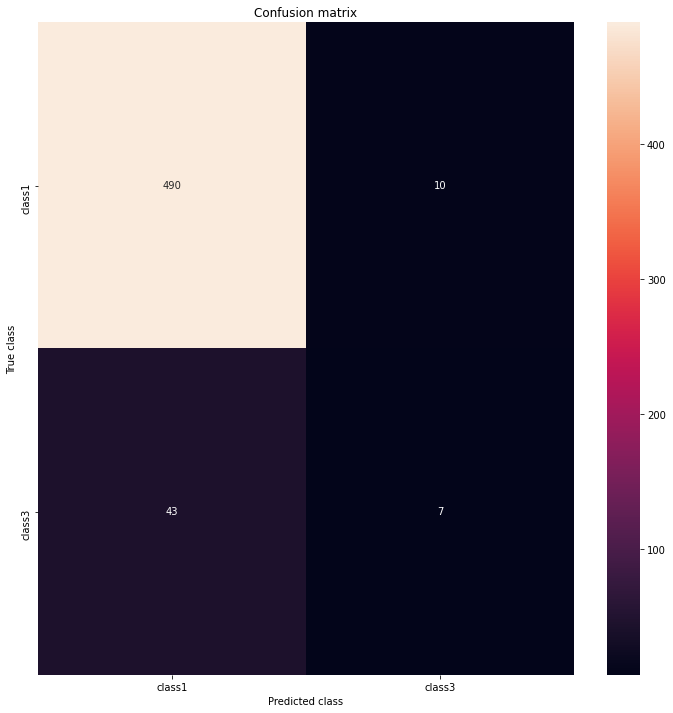

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
LABELS = ["class1","class3"]
threshold_fixed = 4000
pred_y = [1.0 if e > threshold_fixed else 3.0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Step 15: Printing the Classification Report

In [ ]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

         1.0       0.92      0.98      0.95       500
         3.0       0.41      0.14      0.21        50

    accuracy                           0.90       550
   macro avg       0.67      0.56      0.58       550
weighted avg       0.87      0.90      0.88       550

